<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#SVC" data-toc-modified-id="SVC-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>SVC</a></span></li><li><span><a href="#SGDClassifier" data-toc-modified-id="SGDClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>SGDClassifier</a></span></li><li><span><a href="#LGBM" data-toc-modified-id="LGBM-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>LGBM</a></span></li><li><span><a href="#FastText" data-toc-modified-id="FastText-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>FastText</a></span></li><li><span><a href="#Результаты-работы-моделей" data-toc-modified-id="Результаты-работы-моделей-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Результаты работы моделей</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» с FastText

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import re
#import torch              
#import transformers      
from tqdm import notebook

from time import perf_counter
import optuna
from optuna.integration import OptunaSearchCV

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import fasttext

import warnings
warnings.filterwarnings('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\ProgramData\Anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\ProgramData\Anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [2]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Oleg\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Oleg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Oleg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Подготовка

In [3]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=[0])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [5]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Соотношение классов в датасете.

In [6]:
data.value_counts(subset='toxic',normalize=True)

toxic
0    0.898388
1    0.101612
dtype: float64

Функция очистки текста от ненужных символов, пунктуации и чисел.

In [7]:
def clean_text(text):
    
    text = (text.str.lower() \
             .str.replace(r'[^\sa-zA-Z0-9@\[\]]',  ' ', regex = True) \
             .str.replace(r'\n', ' ') \
             .str.replace(r'\w*\d+\w*',  '', regex = True) \
             .str.replace('\s{2,}',  " ", regex = True))
    
    return text

Функция для лемманизации текста.

In [8]:
def lemmatize(text):
    wnl = WordNetLemmatizer()
    text = text.apply(nltk.word_tokenize)
    return text.apply(lambda tokens: " ".join([wnl.lemmatize(token) for token in tokens])) #if token not in stopw

**TF-IDF**

Выгрузим стоп слова.

In [9]:
stopwords = list(set(nltk_stopwords.words('english')))

Применим функции очистки и лемманизации слов текста. Сохраним в отдельный столбец датафрейма.

In [10]:
%%time
data['preprocessed_text'] = clean_text(data['text'])

Wall time: 9.17 s


In [11]:
%%time
data['preprocessed_text'] = lemmatize(data['preprocessed_text'])

Wall time: 1min 4s


In [12]:
data.head()

,text,toxic,preprocessed_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...


**Вывод:**
* Рассмотрен датасет комментариев в интернет-магазине с разметкой о токсичности правок.
* Проведена очистка текста от ненужных символов, пунктуации и чисел.
* Проведена лемманизация слов в тексте

## Обучение

**Pipeline:**

* Text Cleaner
* Text Lemma
* TF IDF
* Model

Разделим данные на обучающую и тестовую выборки.

In [13]:
features = data['preprocessed_text']
target = data['toxic']

features_split, features_test, target_split, target_test = train_test_split(features, target, test_size=0.2)
features_train, features_val, target_train, target_val = train_test_split(features_split, target_split, test_size=0.25)

Функция для сбора результатов работы моделей.

In [14]:
def ModelResults(model_search, model_name, results):
    
    model = model_search.best_estimator_
    
    #Определим время fit модели 
    t_start_1 = perf_counter()
    model.fit(features_train, target_train)
    t_stop_1 = perf_counter()

    #Определим время predict модели 
    t_start_2 = perf_counter()
    p_val = model.predict(features_val)
    t_stop_2 = perf_counter()

    results[model_name] = [abs(model_search.best_score_), f1_score(target_val, p_val),t_stop_1 - t_start_1, t_stop_2 - t_start_2]

    #pd.DataFrame(model.feature_importances_, 
                       #index = features_train.columns, 
                       #columns =['Importance']).sort_values(by='Importance').plot(kind='barh', figsize = (18,6), title ='Feature Importances')
    #plt.show()

In [15]:
# Зададимся random state
RANDOM_STATE = 808

In [16]:
# Зададим StratifiedKFold для разбиение на стратифицированные выборки при кросс-валидации
skf = StratifiedKFold(n_splits=3)

In [17]:
# Словарь для результатов работы рассматриваемых моделей
results = {}

### LogisticRegression

In [18]:
%%time

log_pipe = Pipeline([('tfidf', TfidfVectorizer(min_df=2, max_df=0.8, stop_words=stopwords, sublinear_tf=True)), 
                     ('model', LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE))])

parameters = {'model__solver': optuna.distributions.CategoricalDistribution(['liblinear', 'saga']),
                'model__C': optuna.distributions.FloatDistribution(1, 100, log=True)}


optuna_search_log = OptunaSearchCV(log_pipe, parameters, n_trials=30, cv=skf, n_jobs=-1, scoring='f1', random_state=RANDOM_STATE) 
optuna_search_log.fit(features_train, target_train)

print('\n')
print(f'Лучшие параметры: {optuna_search_log.best_params_}')
print(f'F1 на тренировочной выборке: {abs(optuna_search_log.best_score_)}')
display(optuna_search_log.best_estimator_)
ModelResults(optuna_search_log, 'LogisticRegression', results)

[I 2023-02-21 22:45:44,004] A new study created in memory with name: no-name-29249a4d-6960-4017-89ed-0e90718c1abc
[I 2023-02-21 22:48:51,632] Trial 13 finished with value: 0.7548167436445516 and parameters: {'model__solver': 'liblinear', 'model__C': 10.123047987693825}. Best is trial 13 with value: 0.7548167436445516.
[I 2023-02-21 22:48:51,959] Trial 5 finished with value: 0.7239794981226519 and parameters: {'model__solver': 'saga', 'model__C': 14.968471445797686}. Best is trial 13 with value: 0.7548167436445516.
[I 2023-02-21 22:48:52,551] Trial 6 finished with value: 0.7549941561779145 and parameters: {'model__solver': 'liblinear', 'model__C': 4.2520385611107345}. Best is trial 6 with value: 0.7549941561779145.
[I 2023-02-21 22:48:53,427] Trial 4 finished with value: 0.751916468814164 and parameters: {'model__solver': 'liblinear', 'model__C': 1.929370973226722}. Best is trial 6 with value: 0.7549941561779145.
[I 2023-02-21 22:48:53,642] Trial 14 finished with value: 0.75159533761792



Лучшие параметры: {'model__solver': 'saga', 'model__C': 4.013898901379134}
F1 на тренировочной выборке: 0.760681151035238


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.8, min_df=2,
                                 stop_words=["that'll", 'him', 'up', 'again',
                                             'yours', 'wasn', 've', 'a', 'each',
                                             'their', "you'd", 'her', 'then',
                                             'wouldn', 'we', 'don', 'will',
                                             'an', 'those', 'until', 'than',
                                             'too', 'some', 'your', 'on',
                                             'such', 'ma', 'mustn', 'himself',
                                             "won't", ...],
                                 sublinear_tf=True)),
                ('model',
                 LogisticRegression(C=4.013898901379134,
                                    class_weight='balanced', random_state=808,
                                    solver='saga'))])

Wall time: 6min 7s


### SVC

In [19]:
%%time

svc_pipe =  Pipeline([('tfidf', TfidfVectorizer(min_df=2, max_df=0.8, stop_words=stopwords, sublinear_tf=True)), 
                     ('model', LinearSVC(class_weight='balanced', random_state=RANDOM_STATE))])

parameters = {'model__C': optuna.distributions.FloatDistribution(0.1, 100, log=True)}

optuna_search_svc = OptunaSearchCV(svc_pipe, parameters, n_trials=50, cv=skf, n_jobs=-1, scoring='f1', random_state=RANDOM_STATE) 
optuna_search_svc.fit(features_train, target_train)

print('\n')
print(f'Лучшие параметры: {optuna_search_svc.best_params_}')
print(f'F1 на тренировочной выборке: {abs(optuna_search_svc.best_score_)}')
display(optuna_search_svc.best_estimator_)
ModelResults(optuna_search_svc, 'SVC', results)

[I 2023-02-21 22:51:51,768] A new study created in memory with name: no-name-60a3d16e-452c-469a-847c-b82d5bbd75f4
[I 2023-02-21 22:54:47,970] Trial 8 finished with value: 0.7515209040308871 and parameters: {'model__C': 0.5920017077468036}. Best is trial 8 with value: 0.7515209040308871.
[I 2023-02-21 22:54:57,896] Trial 0 finished with value: 0.7291566206103535 and parameters: {'model__C': 4.883136219603911}. Best is trial 8 with value: 0.7515209040308871.
[I 2023-02-21 22:54:57,960] Trial 2 finished with value: 0.7425658439908126 and parameters: {'model__C': 1.713654062491799}. Best is trial 8 with value: 0.7515209040308871.
[I 2023-02-21 22:54:58,232] Trial 9 finished with value: 0.7533332540733149 and parameters: {'model__C': 0.3869715658277677}. Best is trial 9 with value: 0.7533332540733149.
[I 2023-02-21 22:54:58,499] Trial 14 finished with value: 0.7438038845911529 and parameters: {'model__C': 1.5785747188059918}. Best is trial 9 with value: 0.7533332540733149.
[I 2023-02-21 22:



Лучшие параметры: {'model__C': 0.35911738488222683}
F1 на тренировочной выборке: 0.7535397851837288


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.8, min_df=2,
                                 stop_words=["that'll", 'him', 'up', 'again',
                                             'yours', 'wasn', 've', 'a', 'each',
                                             'their', "you'd", 'her', 'then',
                                             'wouldn', 'we', 'don', 'will',
                                             'an', 'those', 'until', 'than',
                                             'too', 'some', 'your', 'on',
                                             'such', 'ma', 'mustn', 'himself',
                                             "won't", ...],
                                 sublinear_tf=True)),
                ('model',
                 LinearSVC(C=0.35911738488222683, class_weight='balanced',
                           random_state=808))])

Wall time: 9min 33s


### SGDClassifier

In [20]:
%%time

sgd_pipe =  Pipeline([('tfidf', TfidfVectorizer(min_df=2, max_df=0.8, stop_words=stopwords, sublinear_tf=True)), 
                     ('model', SGDClassifier(class_weight='balanced', random_state=RANDOM_STATE))])


parameters = {'model__penalty': optuna.distributions.CategoricalDistribution(['l1', 'l2']),
             'model__loss': optuna.distributions.CategoricalDistribution(['modified_huber', 'perceptron', 'epsilon_insensitive']),
             'model__learning_rate': optuna.distributions.CategoricalDistribution(['optimal'])} #, 'invscaling' ,'adaptive'



optuna_search_sgd = OptunaSearchCV(sgd_pipe, parameters, n_trials=50, cv=skf, n_jobs=-1, scoring='f1', random_state=RANDOM_STATE) 
optuna_search_sgd.fit(features_train, target_train)

print('\n')
print(f'Лучшие параметры: {optuna_search_sgd.best_params_}')
print(f'F1 на тренировочной выборке: {abs(optuna_search_sgd.best_score_)}')
display(optuna_search_sgd.best_estimator_)
ModelResults(optuna_search_sgd, 'SGDClassifier', results)

[I 2023-02-21 23:01:24,848] A new study created in memory with name: no-name-e990d928-ef48-4294-80fc-d9314ee46724
[I 2023-02-21 23:04:20,573] Trial 11 finished with value: 0.6995575095029053 and parameters: {'model__penalty': 'l2', 'model__loss': 'perceptron', 'model__learning_rate': 'optimal'}. Best is trial 11 with value: 0.6995575095029053.
[I 2023-02-21 23:04:20,684] Trial 14 finished with value: 0.6267971509543214 and parameters: {'model__penalty': 'l1', 'model__loss': 'perceptron', 'model__learning_rate': 'optimal'}. Best is trial 11 with value: 0.6995575095029053.
[I 2023-02-21 23:04:21,144] Trial 15 finished with value: 0.6971203833440199 and parameters: {'model__penalty': 'l1', 'model__loss': 'epsilon_insensitive', 'model__learning_rate': 'optimal'}. Best is trial 11 with value: 0.6995575095029053.
[I 2023-02-21 23:04:21,191] Trial 6 finished with value: 0.6971203833440199 and parameters: {'model__penalty': 'l1', 'model__loss': 'epsilon_insensitive', 'model__learning_rate': 'o



Лучшие параметры: {'model__penalty': 'l2', 'model__loss': 'modified_huber', 'model__learning_rate': 'optimal'}
F1 на тренировочной выборке: 0.7482718710846098


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.8, min_df=2,
                                 stop_words=["that'll", 'him', 'up', 'again',
                                             'yours', 'wasn', 've', 'a', 'each',
                                             'their', "you'd", 'her', 'then',
                                             'wouldn', 'we', 'don', 'will',
                                             'an', 'those', 'until', 'than',
                                             'too', 'some', 'your', 'on',
                                             'such', 'ma', 'mustn', 'himself',
                                             "won't", ...],
                                 sublinear_tf=True)),
                ('model',
                 SGDClassifier(class_weight='balanced', loss='modified_huber',
                               random_state=808))])

Wall time: 9min 32s


### LGBM

In [21]:
%%time

lgbm_pipe =  Pipeline([('tfidf', TfidfVectorizer(min_df=2, max_df=0.8, stop_words=stopwords, sublinear_tf=True)), 
                     ('model', LGBMClassifier(class_weight='balanced', random_state=RANDOM_STATE))])

lgbm_params = {
    'model__boosting_type' : optuna.distributions.CategoricalDistribution(['gbdt', 'dart']),
    'model__max_depth': optuna.distributions.IntDistribution(100, 300, step=50),
    'model__learning_rate': optuna.distributions.FloatDistribution(0.001, 0.1, log=True),  
    'model__n_estimators': optuna.distributions.IntDistribution(100, 300, step=50)
}


optuna_search_lgbm = OptunaSearchCV(lgbm_pipe, lgbm_params, n_trials=20, cv=skf, 
                                    n_jobs=-1, scoring='f1', random_state=RANDOM_STATE, timeout=600) 
optuna_search_lgbm.fit(features_train, target_train)

#results['LightGBM'] = abs(optuna_search_lgbm.best_score_)

print('\n')
print(f'Лучшие параметры: {optuna_search_lgbm.best_params_}')
print(f'F1 на тренировочной выборке: {abs(optuna_search_lgbm.best_score_)}')
display(optuna_search_lgbm.best_estimator_)
ModelResults(optuna_search_lgbm, 'LightGBM', results)

[I 2023-02-21 23:10:57,601] A new study created in memory with name: no-name-9a05de98-4779-43b2-877f-0a366cc258dc
[I 2023-02-21 23:19:19,465] Trial 10 finished with value: 0.6387893109604591 and parameters: {'model__boosting_type': 'gbdt', 'model__max_depth': 300, 'model__learning_rate': 0.0048261995341648215, 'model__n_estimators': 100}. Best is trial 10 with value: 0.6387893109604591.
[I 2023-02-21 23:20:46,340] Trial 13 finished with value: 0.6860240697146369 and parameters: {'model__boosting_type': 'gbdt', 'model__max_depth': 200, 'model__learning_rate': 0.028008850815355972, 'model__n_estimators': 100}. Best is trial 13 with value: 0.6860240697146369.
[I 2023-02-21 23:20:50,903] Trial 1 finished with value: 0.6641492131494035 and parameters: {'model__boosting_type': 'dart', 'model__max_depth': 250, 'model__learning_rate': 0.03657345463929404, 'model__n_estimators': 100}. Best is trial 13 with value: 0.6860240697146369.
[I 2023-02-21 23:20:56,434] Trial 11 finished with value: 0.66



Лучшие параметры: {'model__boosting_type': 'gbdt', 'model__max_depth': 300, 'model__learning_rate': 0.03208451343698744, 'model__n_estimators': 300}
F1 на тренировочной выборке: 0.7305214915972643


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.8, min_df=2,
                                 stop_words=["that'll", 'him', 'up', 'again',
                                             'yours', 'wasn', 've', 'a', 'each',
                                             'their', "you'd", 'her', 'then',
                                             'wouldn', 'we', 'don', 'will',
                                             'an', 'those', 'until', 'than',
                                             'too', 'some', 'your', 'on',
                                             'such', 'ma', 'mustn', 'himself',
                                             "won't", ...],
                                 sublinear_tf=True)),
                ('model',
                 LGBMClassifier(class_weight='balanced',
                                learning_rate=0.03208451343698744,
                                max_depth=300, n_estimators=300,
                                random_state=808))])

Wall time: 18min 16s


### FastText

Воспользуемся библиотекой FastText от исследовательской лаборатории искусственного интеллекта Facebook. В отличие от векторизации TF-IDF, она использует word embeddings.

In [22]:
%%time
df = data.copy()

# Очистим текст
df['text'] = clean_text(df['text'])

# Разобьем на тестовые и тренировочные данные
splt, test = train_test_split(df[['toxic', 'text']], test_size=0.2)
train, val = train_test_split(splt, test_size=0.25)

# Сохраним целевой признак 
y_true_train = train['toxic']
y_val_true = val['toxic']
y_true_test = test['toxic']

# Для обучения нужен файл, где целевой класс должен начинаться с __label__
train['toxic'] = train['toxic'].apply(lambda x: '__label__' + str(x))

train[['toxic', 'text']].to_csv('train_data.txt', header=False, index=False, sep="\t")
 
# обучаем на 30 эпохах
t_start_fit = perf_counter()
model = fasttext.train_supervised(input='train_data.txt', epoch=30)
t_stop_fit = perf_counter()

# Predict на тренировочной выборке
p_train = model.predict(train['text'].tolist(), k=1)

# Валидационная выборка
t_start_pred = perf_counter()
p_val = model.predict(val['text'].tolist(), k=1)
t_stop_pred = perf_counter()

t_fit = t_stop_fit - t_start_fit
t_pred = t_stop_pred - t_start_pred


def p_unlabeled(p):
    return [int(re.sub('__label__', '', val[0])) for val in p[0]]
    
#results['FastText'] = [None, f1_score(y_true_val, p_unlabeled(p_val)), t_fit, t_pred]  


print(f'F1 на тренировочной выборке выборке: {f1_score(y_true_train, p_unlabeled(p_train))}')

F1 на тренировочной выборке выборке: 0.9609309182813817
Wall time: 22.3 s


Кросс-валидация для *FastText*.

In [23]:
%%time
scores = []
sk = StratifiedKFold(n_splits=3)
for train_idx, val_idx in sk.split(train['text'], train['toxic']): 
    X_train = train['text'].iloc[train_idx]
    y_train = train['toxic'].iloc[train_idx]
    
    X_val = train['text'].iloc[val_idx]
    y_val = train['toxic'].iloc[val_idx]
    
    pd.concat([y_train, X_train], axis=1).to_csv('Cross_val_data.txt', header=False, index=False, sep="\t")
    
    model_ft = fasttext.train_supervised(input='Cross_val_data.txt', epoch=30)

    p = model_ft.predict(X_val.tolist(), k=1)
    
    p_labels_ = [int(re.sub('__label__', '', val[0])) for val in p[0]]
    y_true_val = [int(re.sub('__label__', '', val)) for val in y_val]
    
    score = f1_score(y_true_val, p_labels_)
    scores.append(score) 
cross_val_FT = np.mean(scores)

Wall time: 20.6 s


In [24]:
print(scores)
print(cross_val_FT)

[0.7741719638675143, 0.7772205144798576, 0.7709973753280841]
0.7741299512251519


In [25]:
results['FastText'] = [cross_val_FT, f1_score(y_val_true, p_unlabeled(p_val)), t_fit, t_pred] 

### Результаты работы моделей

In [26]:
res_df = pd.DataFrame(results, index = ['F1_cross_val','F1_Valid', 'Fit time,s', 'Prediction time,s'], columns = results.keys() )
res_df.style.background_gradient()

,LogisticRegression,SVC,SGDClassifier,LightGBM,FastText
F1_cross_val,0.760681,0.753540,0.748272,0.730521,0.774130
F1_Valid,0.734281,0.737784,0.727874,0.727908,0.785294
"Fit time,s",8.726652,4.389654,4.309867,32.943073,8.673178
"Prediction time,s",1.160367,1.188096,1.416336,1.285753,0.436117


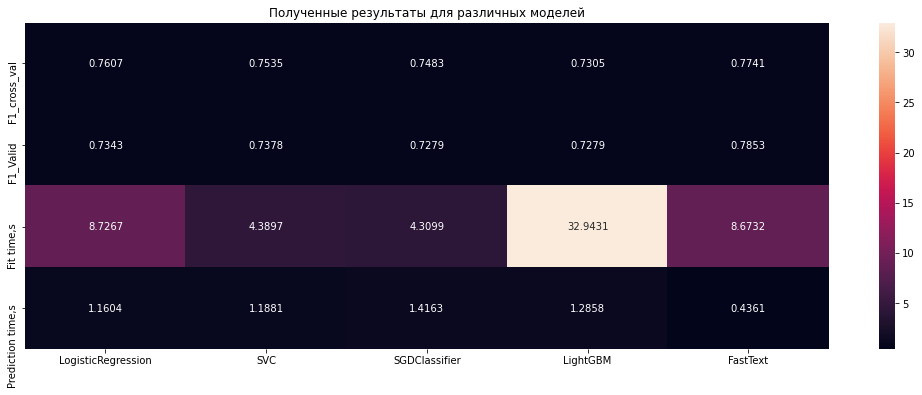

In [27]:
plt.figure(figsize=(18,6))
sns.heatmap(res_df, annot=True, fmt = '.4f')
plt.title('Полученные результаты для различных моделей')
plt.show()

**Вывод:**
* Библиотека FastText наилуший результат по метрике F1 на кросс-валидации и валидационной выборке.

### Тестирование

In [28]:
%%time
p = model.predict(test['text'].tolist(), k=1)
    
print(f'F1 на тестовой выборке: {f1_score(y_true_test, p_unlabeled(p))}')

F1 на тестовой выборке: 0.7881649354737174
Wall time: 530 ms


**Вывод:** Полученная метрика на тестовой выборке удовлетворяет условиям технического задания.

## Выводы

- Рассмотрен датасет комментариев в интернет-магазине с разметкой о токсичности правок.Проведена очистка текста от ненужных символов, пунктуации, чисел и лемманизация слов в тексте.Создана матрица TF-IDF признаков.
- Обучены модели для классификации комментариев на позитивные и негативные.
- Рассмотрена библиотека FastText, использующая word embeddings.
- FastText показала наилуший результат, удовлетворяющий условиям ТЗ по метрике F1.